# Electrical Circuit Practice #1

Numpy, Matplotlib, PySpice and ScheDraw
1. Resistive Divider
2. Second-order RC Circuit
3. Simple Diode Circuit
4. Transient Analysis
5. MOS Curves

In [13]:
!pip install PySpice

import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()

In [14]:
from PySpice.Spice.Netlist import Circuit
from PySpice.Spice.Netlist import SubCircuit
from PySpice.Unit import *

In [15]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [16]:
matplotlib.rcParams.update({'font.size':14,
                           'text.usetex':True,
                           'mathtext.fontset':'cm',
                           'mathtext.rm':'serif'})

In [17]:
!pip install schemdraw

import schemdraw
import schemdraw.elements as elm

# Resistive Divider

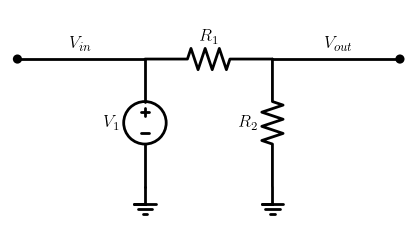

In [18]:
with schemdraw.Drawing() as d:
    d.add(elm.Line().idot().label('$V_{in}$'))
    d.push()
    d.add(elm.SourceV().down().reverse().label('$V_1$'))
    d.add(elm.Ground())
    d.pop()
    d.add(elm.Resistor().label('$R_1$'))
    d.push()
    d.add(elm.Resistor().down().label('$R_2$'))
    d.add(elm.Ground())
    d.pop()
    d.add(elm.Line().dot().label('$V_{out}$'))

In [19]:
circuit = Circuit('Resistive Divider')

circuit.V(1, 'n_in', circuit.gnd, 10@u_V)
circuit.R(1, 'n_in', 'n_out', 2@u_kOhm)
circuit.R(2, 'n_out', circuit.gnd, 3@u_kOhm)

Resistor R2

In [20]:
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
print(simulator)

analysis = simulator.operating_point()

.title Resistive Divider
V1 n_in 0 10V
R1 n_in n_out 2kOhm
R2 n_out 0 3kOhm
.options TEMP = 25C
.options TNOM = 25C
.end



In [21]:
for node in analysis.nodes.values():
    print(f"Node ({str(node)}): {float(node)} V")

Node (n_out): 6.0 V
Node (n_in): 10.0 V


# Second-order RC Circuit

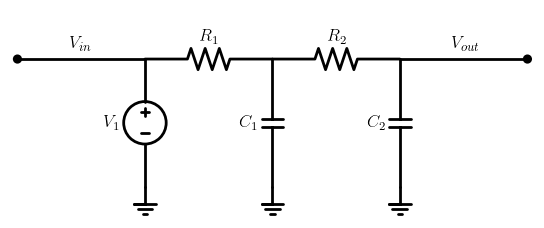

In [22]:
with schemdraw.Drawing() as d:
    d.add(elm.Line().idot().label('$V_{in}$'))
    d.push()
    d.add(elm.SourceV().down().reverse().label('$V_1$'))
    d.add(elm.Ground())
    d.pop()
    d.add(elm.Resistor().label('$R_1$'))
    d.push()
    d.add(elm.Capacitor().down().label('$C_1$'))
    d.add(elm.Ground())
    d.pop()
    d.add(elm.Resistor().label('$R_2$'))
    d.push()
    d.add(elm.Capacitor().down().label('$C_2$'))
    d.add(elm.Ground())
    d.pop()
    d.add(elm.Line().dot().label('$V_{out}$'))

In [37]:
class RC(SubCircuit):
    __nodes__ = ('n1', 'n2')
    def __init__(self, name, R1=1@u_kOhm, C1=10@u_uF):
        SubCircuit.__init__(self, name, *self.__nodes__)
        self.R(1,'n1','n2',R1)
        self.C(2,'n2',circuit.gnd,C1)

In [38]:
circuit = Circuit('Second Order RC Circuit')

In [39]:
circuit.subcircuit(RC(name='RC_BLOCK', C1=1@u_uF))

In [40]:
circuit.SinusoidalVoltageSource(1, 'n_in', circuit.gnd, amplitude=1@u_V)
circuit.X('1', 'RC_BLOCK', 'n_in', 'n_out')
circuit.X('2', 'RC_BLOCK', 'n_out', circuit.gnd)
print(circuit)

.title Second Order RC Circuit
.subckt RC_BLOCK n1 n2
R1 n1 n2 1kOhm
C2 n2 0 1uF
.ends RC_BLOCK
V1 n_in 0 DC 0V AC 1V SIN(0V 1V 50Hz 0s 0Hz)
X1 n_in n_out RC_BLOCK
X2 n_out 0 RC_BLOCK



In [41]:
simulator = circuit.simulator(temperature=25, nominall_temperature=25)
analysis = simulator.ac(start_frequency=1@u_Hz, stop_frequency=10@u_MHz, number_of_points=10, variation='dec')

In [42]:
frequency = analysis.frequency
v_out = np.array(analysis['n_out'])

In [43]:
gain = 20 * np.log10(np.absolute(v_out))
phase = np.angle(v_out, deg=True) * 2

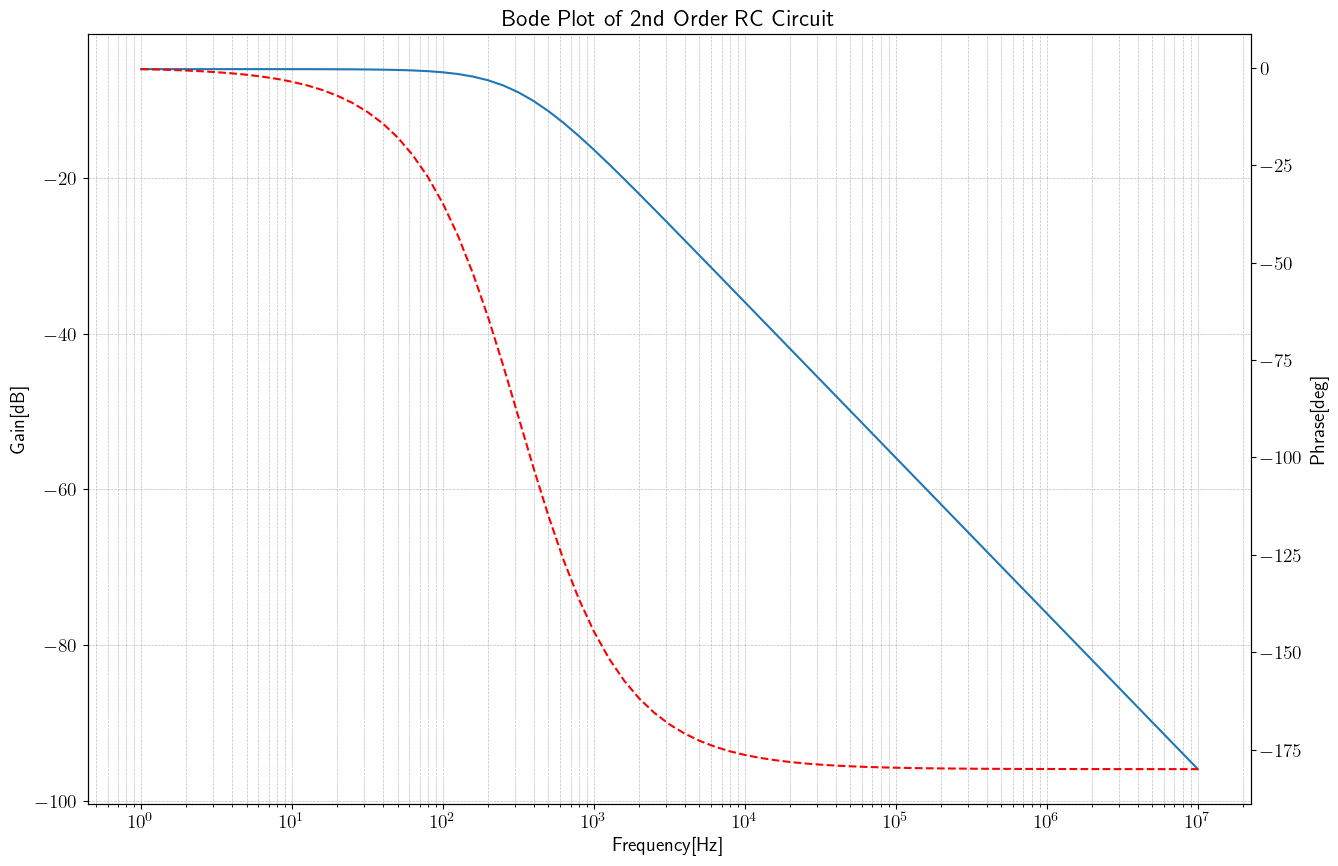

In [44]:
fig, ax1 = plt.subplots(figsize=(15,10))

#setup plot
ax1.set(xlabel = "Frequency[Hz]",
       ylabel = "Gain[dB]",
       title = "Bode Plot of 2nd Order RC Circuit")

ax2 = ax1.twinx()

ax2.set_ylabel("Phrase[deg]")

ax1.set_xscale("log")
ax1.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5, which='both')

ax1.plot(frequency, gain)
ax2.plot(frequency, phase, linestyle='dashed', color='red')

plt.show()

# Simple Diode Circuit

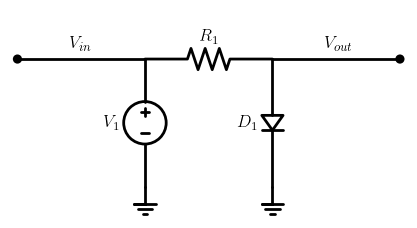

In [45]:
with schemdraw.Drawing() as d:
    d.add(elm.Line().idot().label('$V_{in}$'))
    d.push()
    d.add(elm.SourceV().down().reverse().label('$V_1$'))
    d.add(elm.Ground())
    d.pop()
    d.add(elm.Resistor().label('$R_1$'))
    d.push()
    d.add(elm.Diode().down().label('$D_1$'))
    d.add(elm.Ground())
    d.pop()
    d.add(elm.Line().dot().label('$V_{out}$'))

In [46]:
circuit = Circuit('Diode Circuit')

In [47]:
circuit.V(1, 'n_in', circuit.gnd, 1@u_V)
circuit.R(1, 'n_in', 'n_out', 1@u_kOhm)
print(circuit)

.title Diode Circuit
V1 n_in 0 1V
R1 n_in n_out 1kOhm



In [48]:
"""
.model 1N4148 D (BV=110 CJ0=7.04e-13 FC=0.5 IBV=0.0001 IS=4.352e-09 M=0.03 N=1.906 RS=0.6458 TT=3.48e-09 VJ)
"""
circuit.model('1N4148', 'D',
             IS = 4.352E-09, N = 1.906, BV = 110,
             IBV = 0.0001, RS = 0.6458, CJ0 = 7.04E-13,
             VJ = 0.869, M = 0.03, FC = 0.5, TT = 3.48E-9)

<class 'PySpice.Spice.Netlist.DeviceModel'> 1N4148

In [49]:
circuit.D(1, 'n_out', circuit.gnd, model='1N4148')

Diode D1

In [50]:
print(circuit)

.title Diode Circuit
V1 n_in 0 1V
R1 n_in n_out 1kOhm
D1 n_out 0 1N4148
.model 1N4148 D (BV=110 CJ0=7.04e-13 FC=0.5 IBV=0.0001 IS=4.352e-09 M=0.03 N=1.906 RS=0.6458 TT=3.48e-09 VJ=0.869)



In [51]:
simulator = circuit.simulator(temperature=25, nominall_temperature=25)
analysis = simulator.dc(V1=slice(0, 1, 0.001))

In [52]:
current_name = str(analysis['V1'])
current_values = np.array(analysis['V1'])

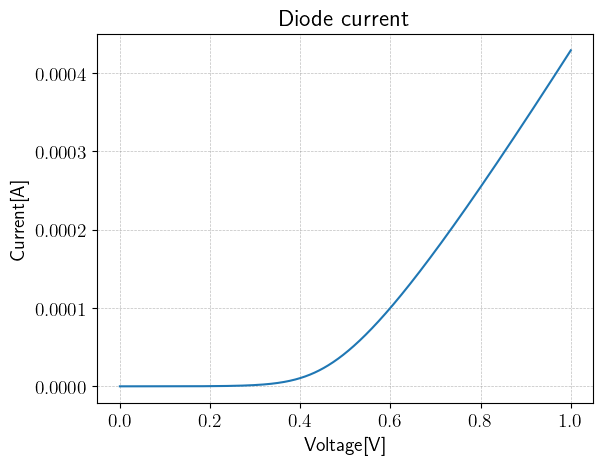

In [53]:
fig, ax = plt.subplots()

#setup plot
ax.set(xlabel="Voltage[V]",
      ylabel="Current[A]",
      title="Diode current")

ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)

x = np.linspace(0,1,len(current_values))
ax.plot(x, -current_values)

plt.show()

# Transient Analysis

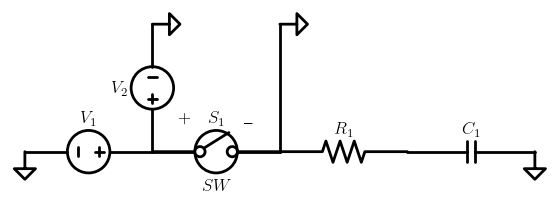

In [54]:
with schemdraw.Drawing() as d:
    d.add(elm.GroundSignal())
    d.add(elm.SourceV().right().label('$V_1$'))
    d.add(elm.Switch().label('$SW$',loc='bottom', ofst=0.5))
    d.push()
    d.add(elm.Source().left().label(('–','$S_1$','+')))
    d.add(elm.SourceV().up().reverse().label('$V_2$'))
    d.add(elm.GroundSignal().up())
    d.pop()
    d.push()
    d.add(elm.Line().up())
    d.add(elm.GroundSignal().up())
    d.pop()
    d.add(elm.Resistor().label('$R_1$'))
    d.add(elm.Capacitor().label('$C_1$'))
    d.add(elm.GroundSignal())


In [55]:
circuit = Circuit('Charging Capacitor')

circuit.V(1, 'n_in', 0, 5)
circuit.PulseVoltageSource(2, 'n_swp', 0, initial_value=-1, pulsed_value=1, pulse_width=1, period=2,
                          delay_time=2@u_ns, rise_time=0, fall_time=0, phase=None, dc_offset=0)
circuit.VoltageControlledSwitch(1, 'n_r1', 'n_in', 'n_swp', 0, model='switch1')
circuit.model('switch1', 'SW', Ron=.002@u_Ohm, Roff=1@u_Ohm)
circuit.R(1, 'n_r1', 'n_c1', 1@u_kOhm)
circuit.C(1, 'n_c1', 0, 1@u_pF, ic=2@u_V)

Capacitor C1

In [56]:
simulator = circuit.simulator(temperature=25, nominall_temperature=25)
analysis = simulator.transient(step_time=0.01E-9, end_time=6E-9, use_initial_condition=True)

In [57]:
time_values = analysis.time
v_pulse = analysis.nodes['n_swp']
v_c1 = analysis.nodes['n_c1']

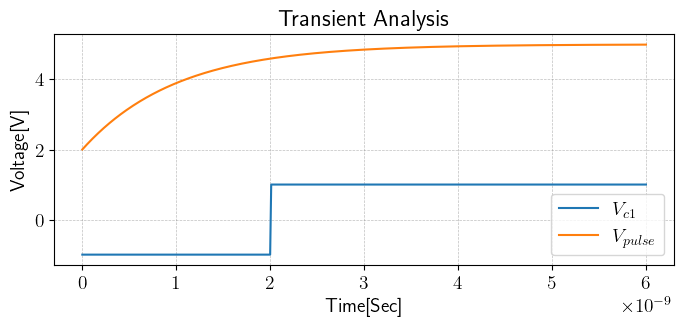

In [58]:
fig, ax = plt.subplots(figsize=(8,3))

#setup plot
ax.set(xlabel="Time[Sec]",
      ylabel="Voltage[V]",
      title="Transient Analysis")

ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)

ax.plot(time_values, v_pulse, label='$V_{c1}$')
ax.plot(time_values, v_c1, label='$V_{pulse}$')
ax.legend()

plt.show()

# MOS Curves

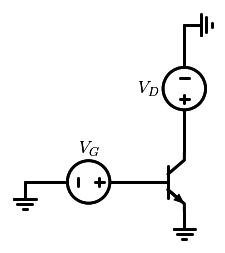

In [59]:
schemdraw.Drawing(
    Q1 := elm.BjtNpn(),
    elm.SourceV().left().reverse().at((Q1, 'base')).label('$V_G$'),
    elm.Ground(),
    elm.SourceV().up().reverse().at((Q1, 'collector')).label('$V_D$'),
    elm.Ground().up(),
    elm.Ground().at((Q1, 'emitter'))
    )

In [60]:
def mos_circuit(params=None):
    
    d = {'vg':1, 'vd':2, 'length':1E-6, 'width':10E-6}
    if params:
        for k, v in params.items():
            d[k] = v
    
    circuit = Circuit('MOS Circuit')
    circuit.model('NMOS-SH', 'nmos', Kp=190E-6, Vto=0.57, Lambda=0.16, Gamma=0.50, Phi=0.7)
    circuit.V('G', 'VG', 0, d['vg'])
    circuit.V('D', 'VD', 0, d['vd'])
    circuit.M(1, 'VD', 'VG', 0, 0, model='NMOS-SH', l=d['length'], w=d['width'])
    return circuit

In [61]:
def sweep_source(first_source_name, first_source_range, second_source_name, second_source_range):
    y = []
    
    for s in second_source_range:
        circuit = mos_circuit({f'{second_source_name}':s})
        simulator = circuit.simulator(temperature=25, nominal_temperature=25)
        if first_source_name == 'vg':
            analysis = simulator.dc(VG=first_source_range)
        else:
            analysis = simulator.dc(VD=first_source_range)
        y.append(- np.array(analysis.branches['vd']))
        
    x = np.array(analysis.nodes[first_source_name])
    return x, y

In [62]:
def plot(x_label, y_label, title, first_source_name, x, y, second_source_name, second_source_range, func=lambda x: x):
    fig, ax = plt.subplots(figsize=(8,4))
    
    #setup plot
    ax.set(xlabel=x_label,
          ylabel=y_label,
          title=title)
    
    ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)
    
    for i, s in enumerate(second_source_range):
        ax.plot(x, func(y[i]), label=f'{second_source_name} = {str(s)}V')
    
    ax.legend()
    plt.show()

# Plot I<sub>D</sub> vs. V<sub>DS</sub> as V<sub>GS</sub> varied

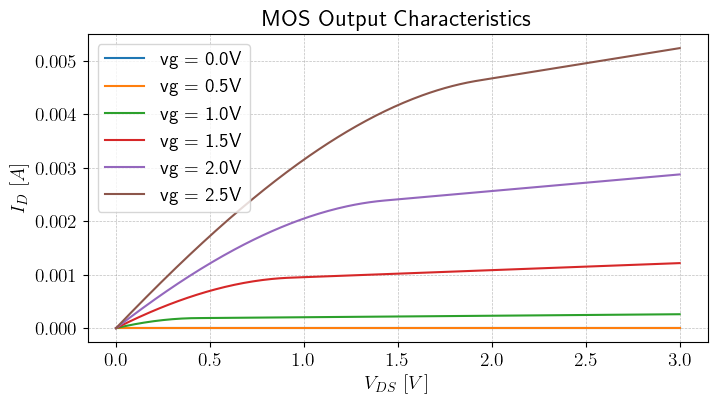

In [63]:
first_source_name = 'vd'
first_source_range = slice(0, 3, .01)
second_source_name = 'vg'
second_source_range = np.arange(0, 3, 0.5)

x, y = sweep_source(first_source_name, first_source_range, second_source_name, second_source_range)

x_label = "$V_{DS}\ [V]$"
y_label = "$I_{D}\ [A]$"
title = "MOS Output Characteristics"

plot(x_label, y_label, title, first_source_name, x, y, second_source_name, second_source_range)

# Plot I<sub>D</sub> vs. V<sub>GS</sub> as V<sub>DS</sub> varied

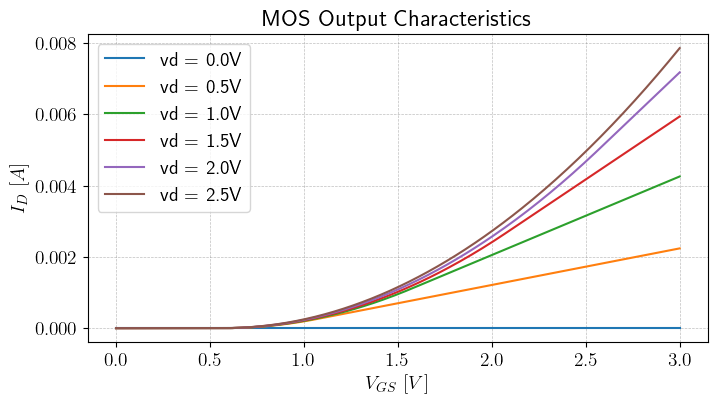

In [64]:
first_source_name = 'vg'
first_source_range = slice(0, 3, .01)
second_source_name = 'vd'
second_source_range = np.arange(0, 3, 0.5)

x, y = sweep_source(first_source_name, first_source_range, second_source_name, second_source_range)

x_label = "$V_{GS}\ [V]$"
y_label = "$I_{D}\ [A]$"
title = "MOS Output Characteristics"

plot(x_label, y_label, title, first_source_name, x, y, second_source_name, second_source_range)

# Plot g<sub>m</sub> vs. V<sub>GS</sub> as V<sub>DS</sub> varied

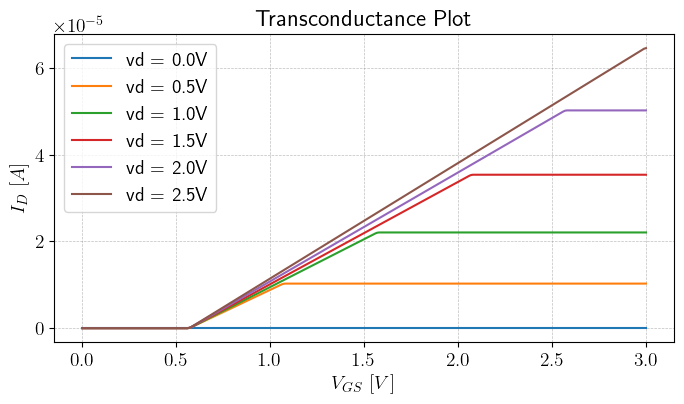

In [65]:
first_source_name = 'vg'
first_source_range = slice(0, 3, .01)
second_source_name = 'vd'
second_source_range = np.arange(0, 3, 0.5)

x, y = sweep_source(first_source_name, first_source_range, second_source_name, second_source_range)

x_label = "$V_{GS}\ [V]$"
y_label = "$I_{D}\ [A]$"
title = "Transconductance Plot"

plot(x_label, y_label, title, first_source_name, x, y, second_source_name, second_source_range, np.gradient)

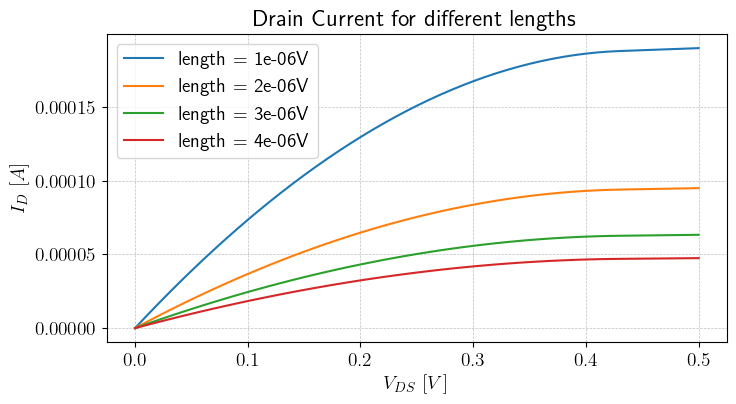

In [66]:
first_source_name = 'vd'
first_source_range = slice(0, 0.5, .01)
second_source_name = 'length'
second_source_range = np.arange(1, 5, 1) * 1E-6

x, y = sweep_source(first_source_name, first_source_range, second_source_name, second_source_range)

x_label = "$V_{DS}\ [V]$"
y_label = "$I_{D}\ [A]$"
title = "Drain Current for different lengths"

plot(x_label, y_label, title, first_source_name, x, y, second_source_name, second_source_range)

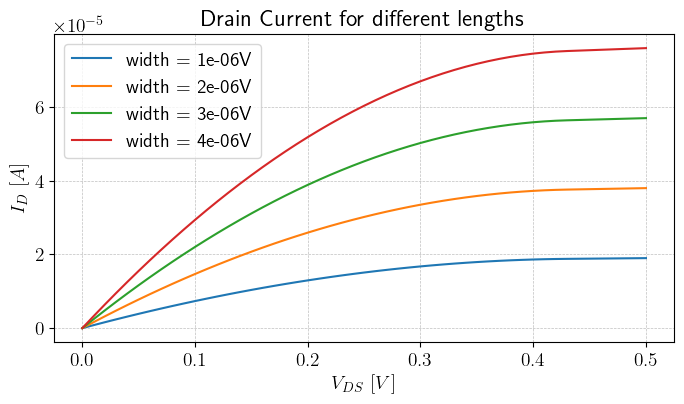

In [67]:
first_source_name = 'vd'
first_source_range = slice(0, 0.5, .01)
second_source_name = 'width'
second_source_range = np.arange(1, 5, 1) * 1E-6

x, y = sweep_source(first_source_name, first_source_range, second_source_name, second_source_range)

x_label = "$V_{DS}\ [V]$"
y_label = "$I_{D}\ [A]$"
title = "Drain Current for different lengths"

plot(x_label, y_label, title, first_source_name, x, y, second_source_name, second_source_range)